In [22]:
%%capture
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes

!yes | pip3 uninstall pandas
!yes | pip3 uninstall geopandas

!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;
!pip3 install pandas
!pip3 install geopandas==0.7.0
!pip3 install matplotlib==3.1.0
!pip3 install osmapi
!pip3 install geopy
!pip3 install plotly

In [23]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import osmapi as osm
import time
from collections import deque
from tqdm import tqdm
from itertools import islice

In [11]:
# !unzip /content/utilities.zip 

Archive:  /content/utilities.zip
227f911b6327408132d926a89730007bfee5f45f
   creating: utilities-227f911b6327408132d926a89730007bfee5f45f/
   creating: utilities-227f911b6327408132d926a89730007bfee5f45f/.github/
   creating: utilities-227f911b6327408132d926a89730007bfee5f45f/.github/ISSUE_TEMPLATE/
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/.github/ISSUE_TEMPLATE/bug_report.md  
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/.gitignore  
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/LICENSE  
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/README.md  
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/__init__.py  
 extracting: utilities-227f911b6327408132d926a89730007bfee5f45f/requirements.txt  
   creating: utilities-227f911b6327408132d926a89730007bfee5f45f/utils/
  inflating: utilities-227f911b6327408132d926a89730007bfee5f45f/utils/__init__.py  
  inflating: utilities-227f911b6327408132d926a89730007

In [24]:
from utilities import *

# New Section

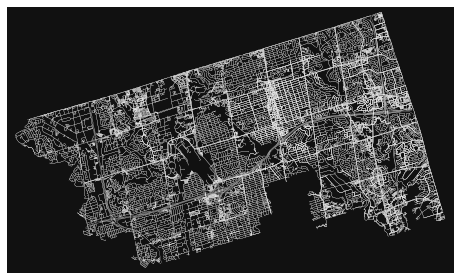

In [25]:
place = 'North York, Ontario, Canada'
G = ox.graph_from_place(place)
fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)  # display the city of North York 

In [26]:
nodes, edges = ox.graph_to_gdfs(G)      # Convert node and edge GeoDataFrames to a MultiDiGraph.
print("Nodes:\n", nodes.head(), '\n')   
print("Edges:\n", edges.head(), '\n')
print("Type:", type(edges)) 

Nodes:
                  y          x  ...            highway                    geometry
1497768  43.745044 -79.332736  ...                NaN  POINT (-79.33274 43.74504)
1497793  43.755035 -79.334502  ...  motorway_junction  POINT (-79.33450 43.75503)
1497798  43.758072 -79.335538  ...                NaN  POINT (-79.33554 43.75807)
1497880  43.729936 -79.330834  ...  motorway_junction  POINT (-79.33083 43.72994)
1497891  43.726895 -79.329920  ...                NaN  POINT (-79.32992 43.72689)

[5 rows x 6 columns] 

Edges:
                                       osmid  oneway  ...           v key
0  [123992403, 30758596, 30758595, 4044007]    True  ...     1497793   0
1                                  30758596    True  ...     1497798   0
2                                  61980359    True  ...  1590264535   0
3  [55346856, 145657882, 36059003, 3969540]    True  ...  1590280324   0
4                      [4044011, 123992219]    True  ...  1561752547   0

[5 rows x 19 columns] 

Type:

In [27]:
# Get all the important things we need to highlight on the map
tags = {
    'amenity':['hospital', 'fire_station'],
}
emergency_locations = ox.geometries_from_place(place, tags=tags)
print(emergency_locations)
df = pd.DataFrame(emergency_locations)  # data frame 
dic = df.to_dict()

          unique_id       osmid  ... wheelchair               wikipedia:en
0    node/609290577   609290577  ...        NaN                        NaN
1   node/1601962650  1601962650  ...        NaN                        NaN
2      way/27006473    27006473  ...        NaN                        NaN
3      way/31372887    31372887  ...        NaN                        NaN
4      way/43806314    43806314  ...        NaN                        NaN
5      way/60428611    60428611  ...        NaN                        NaN
6      way/68021042    68021042  ...        NaN                        NaN
7     way/108700348   108700348  ...        NaN                        NaN
8     way/109199283   109199283  ...        NaN                        NaN
9     way/111664202   111664202  ...        NaN                        NaN
10    way/120882312   120882312  ...        NaN                        NaN
11    way/124105159   124105159  ...        NaN                        NaN
12    way/130468302   130

In [28]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def node_color_and_size(critical_nodes, critical_node_amenity, nodes):
  assert len(critical_nodes) == len(critical_node_amenity)
  node_colors = ['w'] * len(nodes)
  node_size = [0] * len(nodes)
  for i in range(len(critical_nodes)): 
    idx = find_element_in_list(critical_nodes[i], nodes)
    if (idx != -1):
      if (critical_node_amenity[i] == 'fire_station'):
        node_colors[idx] = 'b'
      if (critical_node_amenity[i] == 'hospital'):
        node_colors[idx] = 'r'
      node_size[idx] = 10
  return node_colors, node_size

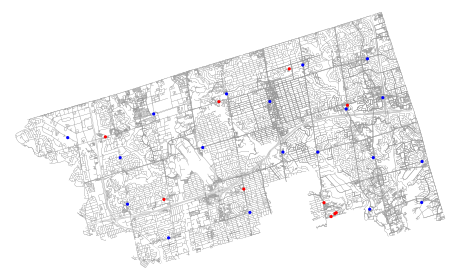

In [29]:
api = osm.OsmApi() # this instantiate the OsmApi class,
# it has many function, we will use NodeGet function.
# For more detail about it check the doc
# http://osmapi.metaodi.ch/#osmapi.OsmApi.OsmApi.NodeGet

critical_amenity_nodes = []
node_amenity = []
all_nodes = list(nodes.to_dict()['osmid'].keys())

for i in range(len(dic['osmid'])):
  if ("node" in dic['unique_id'][i]):
    nodeId= dic['osmid'][i]
    # print("Node - ", i , " :" , nodeId)
  elif ("way" in dic['unique_id'][i]):
    nodeId = dic['nodes'][i][0]
    # print("Way - ", i , " :" , nodeId)

  id_info = api.NodeGet(nodeId)
  point = (id_info['lat'], id_info['lon']) # lat (y), lon (x) 
  pt_nearest_node_euc = ox.get_nearest_node(G, point, method='euclidean')
  critical_amenity_nodes.append(pt_nearest_node_euc)
  node_amenity.append(dic['amenity'][i])
  
  # print(G.nodes[pt_nearest_node_euc])
  # print(pt_nearest_node_euc in all_nodes)

nc, ns = node_color_and_size(critical_amenity_nodes, node_amenity, all_nodes)

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

# The Algorithm

## -------- DFS -----------

In [30]:

# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = critical_amenity_nodes[0])
destination = Node(graph = G, osmid = critical_amenity_nodes[1])

In [31]:
%%time 
bar = tqdm(total=len(G))

route = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.05)
    node = frontier.pop()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route  = child.path()
                found = True
                continue
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 61%|██████    | 21240/35086 [18:30<12:03, 19.13it/s]

The route is 

 [6624988064, 7368052431, 7127096569, 7127096567, 261631317, 261631491, 7824126406, 1814304153, 1814304152, 261631540, 1333963652, 4315968214, 4315968216, 7127096563, 7127096564, 7127096546, 5777975648, 5777975647, 7127096541, 7368092038, 5670217272, 3447489202, 7368092015, 7368092012, 7368092002, 6474228780, 6474235297, 6474235311, 6842674658, 48490673, 1721319579, 6474235326, 7368091985, 7368091987, 7368091989, 48489536, 7244814028, 7244814019, 7244814018, 48487794, 48494741, 48495722, 48495726, 48496115, 253013816, 430878370, 430878300, 4948911358, 414424283, 430877776, 1245025174, 430878081, 430878425, 430877819, 430877721, 7250327562, 7250327570, 430878136, 809117253, 809232794, 809136544, 809136549, 809130585, 809130579, 5978796615, 5978796611, 809126912, 809117284, 430878477, 809126917, 6225873776, 253012447, 430878326, 430878484, 430878131, 430877969, 430877908, 253013434, 48496770, 4589183201, 4589183203, 4589183202, 4589183206, 5908603285, 4590854797, 48498576,

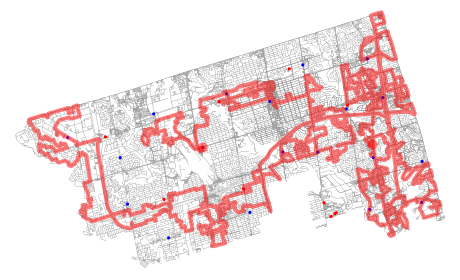

In [ ]:
fig, ax = ox.plot_graph_route(G, route=route, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

## -------- A* -----------

  0%|          | 3/35086 [00:00<23:27, 24.92it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


  1%|          | 219/35086 [00:11<29:48, 19.50it/s]


The route is 

 [6624988064, 7368052431, 7127096569, 7127096567, 7127096562, 7127096563, 7127096564, 7127096546, 5777975648, 5777975647, 7127096541, 7368092038, 5670217272, 3447489202, 414430401, 6636627323, 5672904865, 6636627328, 6636627327, 414431814, 414442700, 2029173546, 408359178, 820085456, 408359174, 2029413823, 7127096573, 7127096583, 7127096581, 7127096579, 7127096577, 2029413818, 4426385363, 4426385357, 4426349250, 2029198247, 2029198632, 2029198250, 4426385346, 6785916853, 6785916854, 7500072820, 5908502238, 429403191, 429402986, 262077320, 262077318, 1015035655, 262077312, 429403101, 429402887, 261734452, 429403159, 429403335, 429403297, 429402926, 429402636, 430559318, 430559593, 429402908, 430559348, 430559127, 931447725, 931447764, 4969555944, 1909080282, 6625545312, 6625545311] 

its cost is

 7532.145000000002


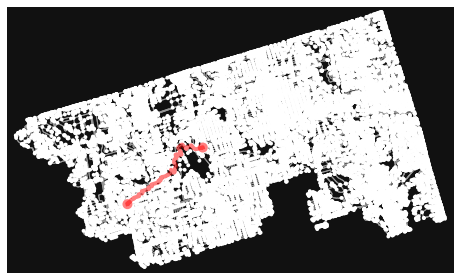

In [33]:
# toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)
toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

%time
route = []
frontier = list()

bar = tqdm(total=len(G)) # for the progress bar

frontier.append(origin)
explored = set()
found = False

while frontier and not found:
    bar.update(1); time.sleep(0.05)
    
    # choose a node based on its heuristic value
    node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
    frontier.remove(node)
    explored.add(node)
    
    # expand its children
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                continue
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

fig, ax = ox.plot_graph_route(G, route)

# Testing Onwards - Ignore

In [ ]:
place = 'University of Toronto'
G = ox.graph_from_place(place)
nodes, edges = ox.graph_to_gdfs(G)

keys = list(nodes.to_dict()['osmid'].keys())
print (keys)


[20979742, 21631731, 24959527, 24959528, 24959535, 24959545, 24959546, 24959547, 24959549, 24959550, 24959551, 24959555, 24959556, 24959559, 24959560, 24960058, 24960060, 24960063, 24960068, 24960070, 24960073, 24960076, 24960080, 50885141, 50885147, 50885160, 50897854, 50897859, 50897869, 50897874, 55808451, 55808512, 55808518, 55808527, 55808564, 55808571, 55808582, 55808839, 59817393, 59817394, 60052037, 60052038, 60052040, 60052042, 60052047, 60052048, 60052049, 60052050, 60654119, 60654120, 60654129, 60654133, 80927418, 80927426, 87475456, 87475463, 123347786, 123347984, 127275360, 127283024, 127284677, 127284680, 127289393, 130170945, 215726254, 239055725, 239055729, 242413453, 243633234, 244213560, 244213561, 249991437, 253815363, 253815365, 253815479, 262732431, 262732432, 262732448, 262817257, 262817259, 299625331, 303255446, 304885460, 304888562, 304890340, 304890341, 304892018, 305862114, 306721038, 306721042, 306721055, 306721057, 306725181, 306725184, 306729816, 306729822,

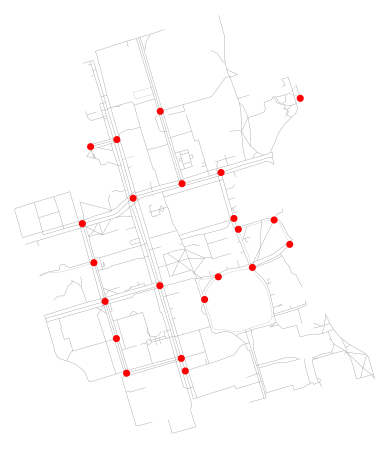

In [ ]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

highlight_nodes = [20979742, 21631731, 24959527, 24959528, 24959535, 24959545, 24959546, 24959547, 24959549, 24959550, 24959551, 24959555, 24959556, 24959559, 24959560, 24960058, 24960060, 24960063, 24960068, 24960070, 24960073, 24960076]
colors = ['w'] * len(keys)
size = [0] * len(keys)
for i in range(len(highlight_nodes)): 
  idx = find_element_in_list(highlight_nodes[i], keys)
  if (idx != -1):
    colors[idx] = 'r'
    size[idx] = 50

fig, ax = ox.plot_graph(G, node_color=colors, node_size=size, edge_linewidth=0.2, bgcolor = 'white')

In [ ]:
api = osm.OsmApi() # this instantiate the OsmApi class,
# it has many function, we will use NodeGet function.
# For more detail about it check the doc
# http://osmapi.metaodi.ch/#osmapi.OsmApi.OsmApi.NodeGet

# for id in size(dic['osmid']):
#   id_info = api.NodeGet(dic['osmid'][3])

node = api.NodeGet(dic['nodes'][3])
lat = node['lat']
lon = node['lon']
# print(node)
pt_nearest_node_euc = ox.get_nearest_node(G, (lat, lon), method='euclidean')
print(node)
print(pt_nearest_node_euc)
G.nodes[pt_nearest_node_euc]

NameError: ignored

In [ ]:
!pip3 install geopy
